# Predictive Approaches in Machine Learning (II)
## Part 2: Reinforcement Learning
#### Prof. Dr. Oliver Junge
Department of Mathematics\
Technical University of Munich\
Germany\
\
July 9, 2022

This Julia notebook provides the code for the experiment conducted in the course. In your Julia environment, the packages `LaTeXStrings`, `StatsBase` and `Plots` need to be installed (by, e.g., issuing the commands

In [1]:
import Pkg; Pkg.add("LaTeXStrings"); Pkg.add("StatsBase"); Pkg.add("Plots");

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/teaching/Data Science/lecture/codes/Project.toml`
  No Changes to `~/Nextcloud/teaching/Data Science/lecture/codes/Manifest.toml`
   Resolving package versions...
    Updating `~/Nextcloud/teaching/Data Science/lecture/codes/Project.toml`
  [2913bbd2] + StatsBase v0.33.18
  No Changes to `~/Nextcloud/teaching/Data Science/lecture/codes/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/teaching/Data Science/lecture/codes/Project.toml`
  No Changes to `~/Nextcloud/teaching/Data Science/lecture/codes/Manifest.toml`


## Preparations

In [2]:
using LinearAlgebra, StatsBase, Plots, LaTeXStrings

In [3]:
StatsBase.sample(Ω, w::Vector{Float64}) = sample(Ω, Weights(w))  
argmax(S) = findall(S .== maximum(S))

# plots the grid of the maze
function plotgrid(n,m)
    plt = Plots.plot(legend=false, aspect_ratio=:equal,
                    grid=false, xlim=(0,n).+0.5, ylim=(0,m).+0.5, axis=false)
    xticks!(1:n, string.(1:n))
    yticks!(1:m, string.(1:m))
    vline!(0.5:1:n+0.5, color=:black)
    hline!(0.5:1:m+0.5, color=:black)
    return plt
end

# plots the maze
function plot(S::CartesianIndices)
    n,m = size(S)
    plt = plotgrid(n,m)
    for i in wall
        plot!([i[1] i[1]], [i[2] i[2]], c=:gray, ms=28, markerstrokewidth=0., markershape=:rect)
    end
    annotate!(🐭[1], 🐭[2], ("🐭", 25, "Helvetica"))
    annotate!(🧀[1], 🧀[2], ("🧀", 25, "Helvetica"))
    return plt
end

# plots a strategy
function plot(π::Matrix{Vector{Float64}})
    plt = plot(S)
    marker = [:ltriangle, :rtriangle, :utriangle, :dtriangle]
    sizes = [15, 15, 10, 10]
    for s in setdiff(S, wall)
        # k = sample(LinearIndices(A), Weights(π[s]))
        k = sample(LinearIndices(A), π[s])
        plot!([s[1] s[1]], [s[2] s[2]], c=:black, ms=sizes[k], shape=marker[k], markerstrokewidth=0.)
    end
    return plt
end

# plots a state-value function
function plot(V::Matrix{Float64})
    plt = plot(S)
    for s in setdiff(S, wall)
        z = V[s]
        plot!([s[1] s[1]], [s[2] s[2]], marker_z=z, ms=28, shape=:rect, markerstrokewidth=0., colorbar=true)
    end
    return plt
end

# plots a path
function plot(path::Vector{Any})
    plt = plot(S)
    δ = 0.5/length(path)
    δy = -0.25
    s_old = 🐭
    for (s,a,r) in path
        plot!([s[1]], [s[2]+δy], ms=8, shape=:circle, color=:black, ls = :solid)
        plot!([s_old[1], s[1]], [s_old[2]+δy, s[2]+δy])
        s_old = s
        δy += δ
    end
    return plt
end
;

## Define the Markov decision process

### state space, action space, discount factor

In [4]:
S = CartesianIndices((6,6))
A = CartesianIndex.([(-1,0), (1,0), (0,1), (0,-1)])
wall = CartesianIndex.([(4,2),(5,2),(6,2),(1,3),(1,4),(3,4),(5,4),(6,4),(1,5),(2,5),(3,5),(1,6),(5,6)])
S´ = setdiff(S,wall)

🐭 = CartesianIndex(1,1)
🧀 = CartesianIndex(6,6)

γ = 0.9;

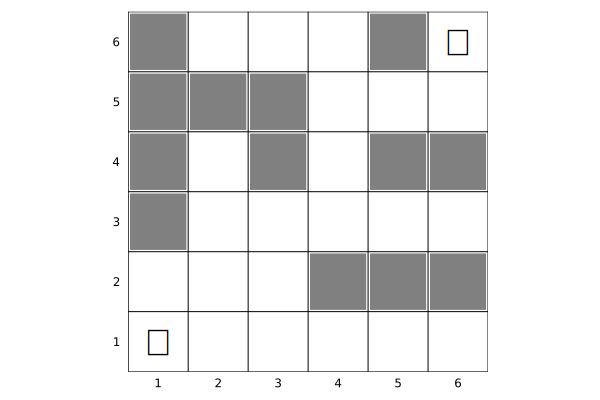

In [5]:
plot(S)

In [5]:
plotly()
savefig("figures/maze.html")
gr();

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/junge/.julia/packages/Plots/8ouqB/src/backends.jl:432


### The transition and reward function
$T(s,a)$ returns a dictionary. Each entry $(r,s') => p$ gives the probability $p$ to move to state $s'$ from state $s$ under the action $a$ and the reward $r$ received for this transition. 

In [6]:
function T(s, a)
    if s == 🧀
        return [(0, s) => 1.0]
    end
    s′ = s + a
    if s′ == 🧀 
        r = 10.
    elseif s′ in S && !(s′ in wall)
        r = 0.
    else
        r = -1.
        s′ = s
    end
    return [(r, s′) => 1.0]
end

T (generic function with 1 method)

In [7]:
s = rand(S)
a = rand(A)
T(s,a)

1-element Vector{Pair{Tuple{Float64, CartesianIndex{2}}, Float64}}:
 (0.0, CartesianIndex(5, 5)) => 1.0

## A stochastic policy
In this example, each action from $A$ is equally likely.

In [8]:
u = [ 0.25 for a in A ]
π = [ u for i = 1:6, j = 1:6 ]
s = rand(S)
a = rand(LinearIndices(A))
π[s][a]

0.25

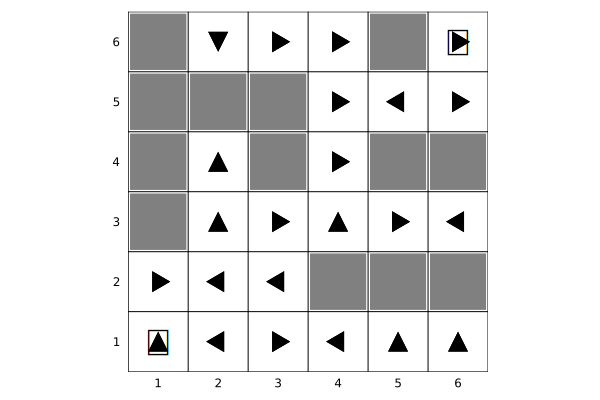

In [9]:
plot(π)

In [11]:
plotly()
savefig("figures/random_policy.html")
gr();

## Initial state-value function
... simply set to $0$ everywhere here.

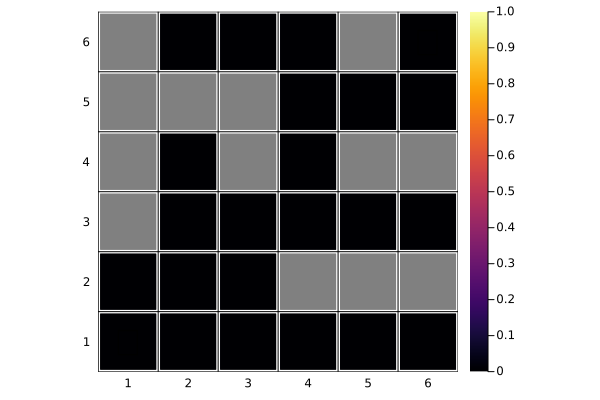

In [10]:
V = zeros(6,6)
plot(V)

## Action-value function
as resulting from a given state value function $V$

In [13]:
Q(V,s,a) = sum( p.*(r + γ*V[s′]) for ((r,s′),p) in T(s,a) )
s, a = rand(S), rand(A)
Q(V,s,a)

0.0

## the Bellman operator

In [14]:
B(V,π) = [ sum(π[s][a] * Q(V,s,A[a]) for a in LinearIndices(A)) for s in S ]

B (generic function with 1 method)

Let's perform one iteration with the Bellman operator to see how the state value function changes.

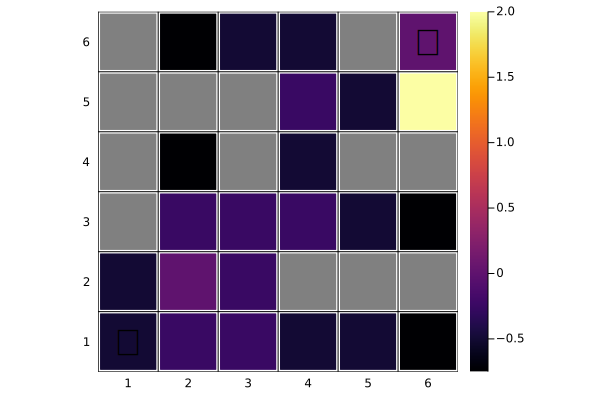

In [15]:
V = B(V,π)
plot(V)

## Policy evaluation
This function computes the state-value function $V^\pi$ associated to a given policy $\pi$ by iterating the Bellman operator until a given relative error of $V^\pi$ is reached.

In [16]:
function policy_evaluation(π; TOL = 1e-4)
    V, V´ = zeros(6,6), ones(6,6)
    while norm(V´ - V)/norm(V) > TOL
        V = V´
        V´ = B(V,π)
    end
    return V
end

policy_evaluation (generic function with 1 method)

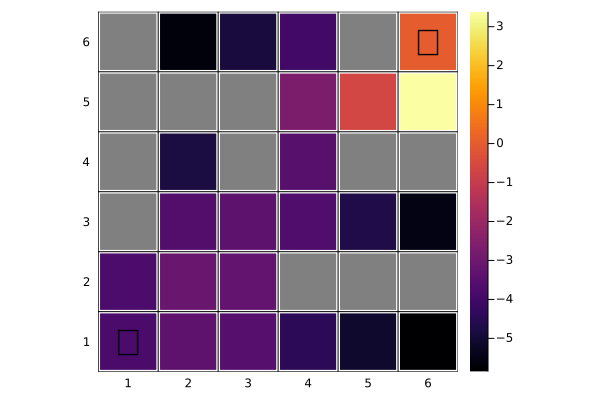

In [17]:
V = policy_evaluation(π)
plot(V)

In [19]:
plotly()
savefig("figures/policy_evaluation.html")
gr();

## Greedy policy
This function computes the greedy policy associated to a given state-value function $V$.

In [18]:
function greedy_policy(V)
    π = [ zeros(4) for i = 1:6, j = 1:6 ]
    
    for s in S
        a_max = argmax( Q(V,s,a) for a in A )
        a = rand(a_max)
        π[s][a] = 1.0
    end
    return π
end

greedy_policy (generic function with 1 method)

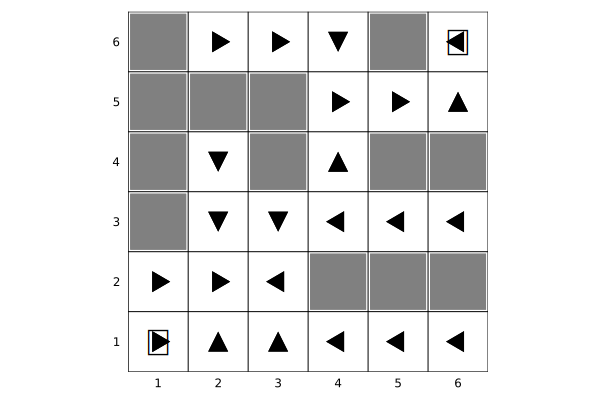

In [19]:
π = greedy_policy(V)
plot(π)

In [24]:
plotly()
savefig("figures/greedy_policy.html")
gr();

... and the value function associated to the greedy policy looks like this.

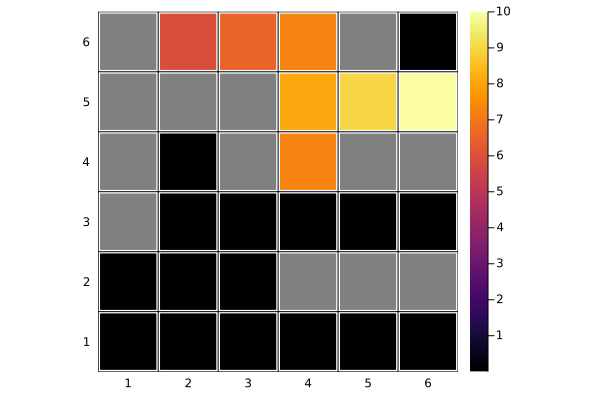

In [20]:
V = policy_evaluation(π)
plot(V)

In [26]:
plotly()
savefig("figures/V_for_greedy_policy.html")
gr();

## Value iteration
... for computing the optimal value function. Again, the iteration is terminated once a prescribed relative error is reached.

In [21]:
function value_iteration(TOL = 1e-4)
    V, V´ = zeros(6,6), ones(6,6)
    while norm(V-V´)/norm(V) > TOL
        V = V´
        V´ = [ maximum( Q(V,s,a) for a in A ) for s in S ]
    end
    return V
end

value_iteration (generic function with 2 methods)

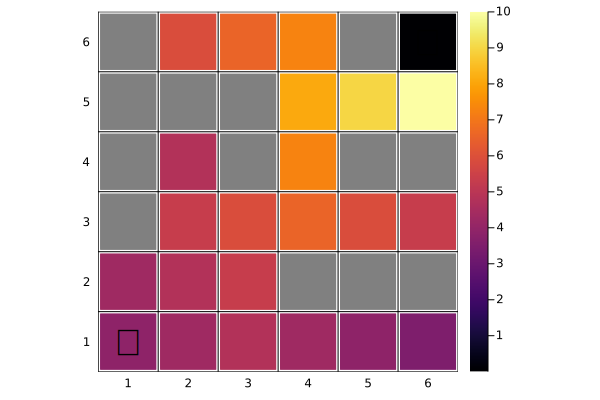

In [22]:
V = value_iteration()
plot(V)

In [31]:
plotly()
savefig("figures/optimal_state-value_function.html")
gr();

Then the optimal policy can be computed as the greedy policy w.r.t. the optimal value function.

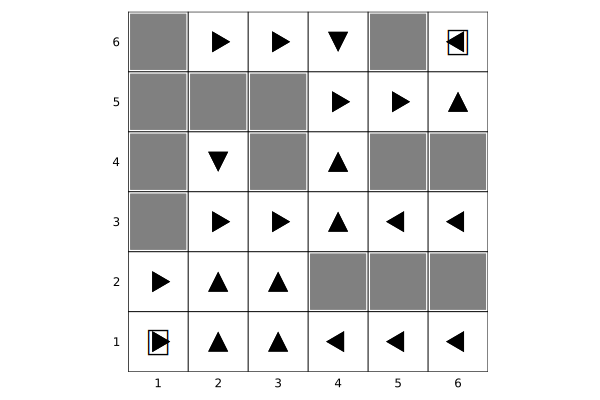

In [23]:
π = greedy_policy(V)
plot(π)

In [33]:
plotly()
savefig("figures/optimal_policy.html")
gr();

An $\varepsilon$-greedy policy ensures that all states will be visited eventually.

In [24]:
function ε_greedy_policy(V; ε = 1e-2)
    π = [ ε*ones(4) for i = 1:6, j = 1:6 ]    
    for s in S
        best = argmax( Q(V,s,a) for a in A )
        a = rand(best)
        π[s][a] = 1.0
        π[s] /= sum(π[s])
    end   
    return π
end

ε_greedy_policy (generic function with 1 method)

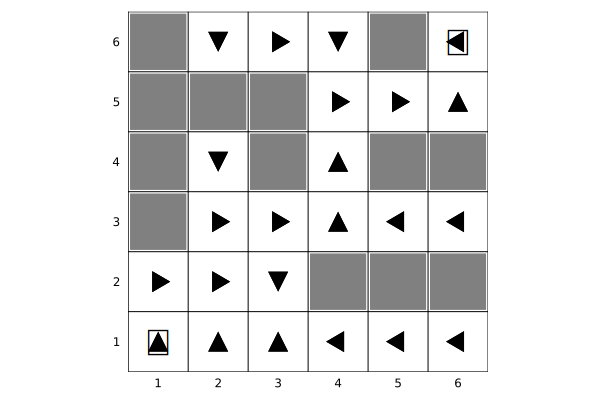

In [25]:
π = ε_greedy_policy(V)
plot(π)

## Learning by experience

The methods in this chapter can be used if no model of the system is available (of course, we will still use the maze model here ...).

Monte Carlo methods are based on evaluating a full trajectory of the system. So let's generate one randomly, based on a given policy.

In [26]:
function simulate(π,s)
    path = []
    while s != 🧀
        a = sample(A, Weights(π[s]))
        (r,s′),p = T(s,a)[1]
        push!(path, (s,a,r))
        s = s′
    end
    push!(path, (🧀,nothing,0.0))
    return path
end

simulate (generic function with 1 method)

Since $\pi$ is still the optimal policy, the mouse reaches the cheese pretty quickly.

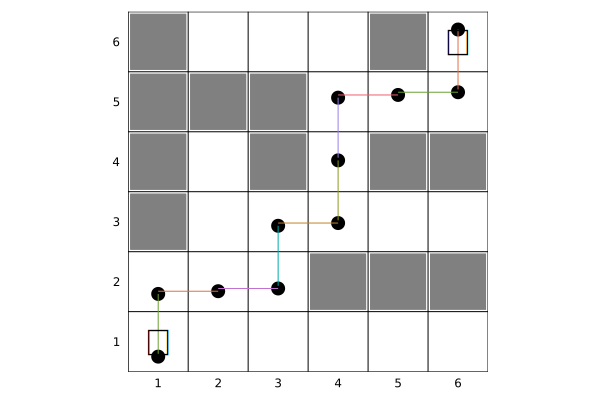

In [27]:
path = simulate(π,🐭)
plot(path)

If, instead, we use a random policy (as initially above), the mouse wanders around much more ...

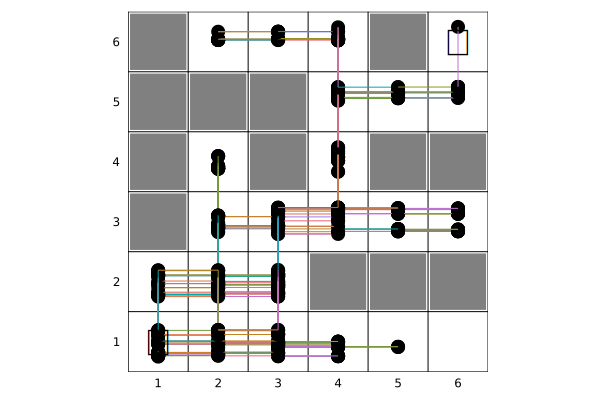

In [28]:
u = [ 0.25 for a in A ]
π = [ u for i = 1:6, j = 1:6 ]
path = simulate(π,🐭)
plot(path)

## Monte Carlo policy evaluation
First, a complete episode is simulated (or recorded if no model is available).
Then, the state-value function is updated using the averaged returns from that data.

In [29]:
function MC_policy_evaluation(π; n = 1000)
    V = rand(6,6)
    for k = 1:n    # episodes
        path = simulate(π, rand(S´))
        g = 0
        for (s,a,r) in path[end:-1:1]
            g = r + γ*g
            V[s] = V[s] + 1/k*(g-V[s])
        end
    end
    return V
end

MC_policy_evaluation (generic function with 1 method)

Let's test this on a random strategy.

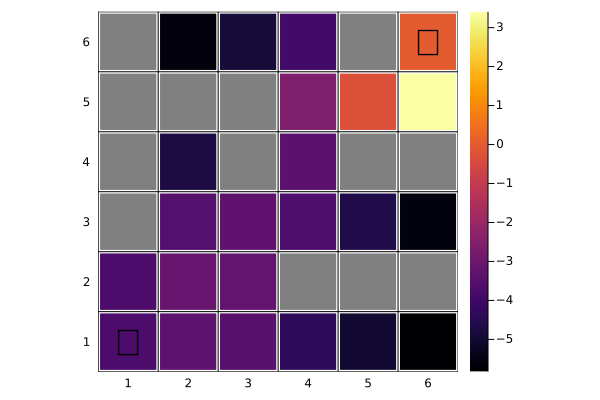

In [30]:
u = [ 0.25 for a in A ]
π = [ u for i = 1:6, j = 1:6 ]
V = MC_policy_evaluation(π)
plot(V)

... and this looks indeed pretty similar to the one got from the fixed point iteration above.

## Temporal difference learning
Instead of running a full episode before updating the state-value function, it is updated while simulating resp. experiencing a path.

In [31]:
function TD(π; n = 100)
    V = zeros(6,6); V[🧀] = 0 
    for k = 1:n                # no of episodes
        s = rand(S´)
        while s != 🧀
            a = sample(A, π[s])
            ((r,s′),_) = T(s,a)[1]
            V[s] = V[s] + 1/k*(r + γ*V[s′]-V[s])
            s = s′
        end
    end
    return V
end

TD (generic function with 1 method)

We compare the state-value function that we got by TD to the one from the fixed point iteration (which serves as the reference solution here) in dependence on the number of episodes.

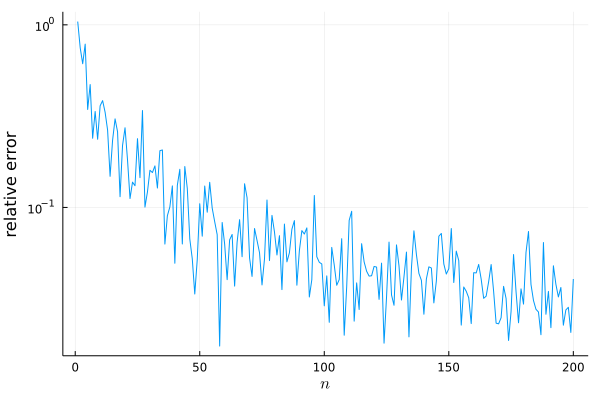

In [32]:
V = policy_evaluation(π); V[wall] .= 0
N = 200   # number of episodes
error = zeros(N)
for n = 1:N  
    Ṽ = TD(π; n = n)
    error[n] = norm(V-Ṽ)/norm(V)
end
Plots.plot(error, xlabel=L"n", ylabel="relative error", legend=false, yaxis=:log)
